# Contraceptive Use in Indonesia: 1987 Study #

## Source: UCI Machine Learning Repository ##
### URL: [WebLink](https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice)


Source:

** Origin: **
- This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey 

** Creator and Donor: **
- [Tjen-Sien Lim](limt@stat.wisc.edu) 

** Relevant Papers:**
- [Lim, T.-S., Loh, W.-Y. & Shih, Y.-S. (1999). A Comparison of Prediction Accuracy, Complexity, and Training Time of Thirty-three Old and New Classification Algorithms. Machine Learning](http://www.stat.wisc.edu/~loh/treeprogs/guide/mach1317.pdf)

In [1]:
from contra_tools.file_retrieve import *
from data_tools.log_reg import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
import bokeh as bk
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, Slider
from bokeh.io import curdoc, show, output_notebook, push_notebook, output_file
from bokeh.layouts import widgetbox, column, row, gridplot
from bokeh.plotting import figure

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline
plt.style.use('bmh')

pink_green = 'PiYG'
paired_colors = 'Paired'


##for CatColorMapper, 
''' 
CatColMap = CategoricalColorMapper(factors =[], palette = [])
Hover = HoverTool(tooltips=[('string label','@column_name')])

plot.add_tools(Hover)
plot.circle(x,y,source=source,color={'field':[column_name],'transform':[CatColMap]})'''

##for gridplot,
'''
layout = gridplot(list of rows)
gridplot shares the toolbar for all plots
'''

##for callbacks,
'''
def callback(attr,old,new):
    [insert Slider function]
    
slider.on_change('value',callback)
'''

##for bokeh server,
'''
curdoc().add_root(layout)

in the shell:

bokeh serve --show myapplication.py
'''

'\ncurdoc().add_root(layout)\n\nin the shell:\n\nbokeh serve --show myapplication.py\n'

In [2]:
'''1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term'''

print('Let\'s make some algorithmic magic!')

Let's make some algorithmic magic!


In [3]:
df = make_df()

In [4]:
df.tail()

,wife_age,wife_edu,husb_edu,num_child,wife_islam,wife_unemployed,husb_occupation,life_std,bad_media,contra_type
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3
1472,17,3,3,1,1,1,2,4,0,3


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age           1473 non-null int64
wife_edu           1473 non-null int64
husb_edu           1473 non-null int64
num_child          1473 non-null int64
wife_islam         1473 non-null int64
wife_unemployed    1473 non-null int64
husb_occupation    1473 non-null int64
life_std           1473 non-null int64
bad_media          1473 non-null int64
contra_type        1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


[]

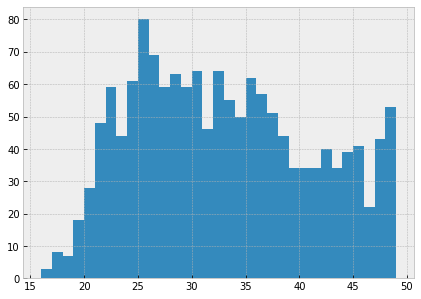

In [6]:
age_range = df.wife_age.max() - df.wife_age.min()

df.wife_age.hist(bins=age_range,figsize=(7,5))
plt.plot()

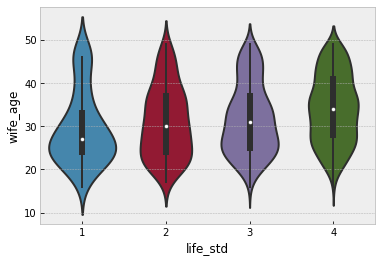

In [7]:
sb.violinplot(x='life_std',y='wife_age',data=df)

#### Binning the # children and age to prep for one-hot encoding

In [8]:
df['num_children'] = pd.cut(df['num_child'],[-1,1,3,6,max(df['num_child'])],labels=['[0-1]','(1-3]','(3-6]','(6-{}]'.format(max(df['num_child']))])

In [9]:
df['num_children'].value_counts()

(1-3]     535
(3-6]     424
[0-1]     373
(6-16]    141
Name: num_children, dtype: int64

In [10]:
df['wife_range'] = pd.cut(df['wife_age'].astype('int64'),bins=[0,24,30,37,43,max(df['wife_age'])],labels=['[18-24]','(24-29]','(29-37]','(37-43]','(43-{}]'.format(max(df['wife_age']))])

In [11]:
df['wife_range'].value_counts()

(24-29]    394
(29-37]    385
[18-24]    276
(37-43]    220
(43-49]    198
Name: wife_range, dtype: int64

In [12]:
df_2 = pd.crosstab(df['wife_range'],df['num_children'],normalize='index')
df_2

num_children,[0-1],(1-3],(3-6],(6-16]
wife_range,,,,
[18-24],0.601449,0.355072,0.043478,0.000000
(24-29],0.314721,0.467005,0.200508,0.017766
(29-37],0.088312,0.394805,0.428571,0.088312
(37-43],0.100000,0.286364,0.422727,0.190909
(43-49],0.136364,0.191919,0.378788,0.292929


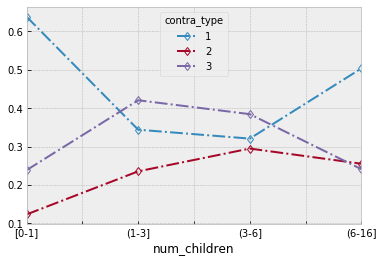

In [13]:
df_3 = pd.crosstab(df['num_children'],df['contra_type'],normalize='index')
df_3.plot(marker='d',markerfacecolor='none',linestyle='-.')

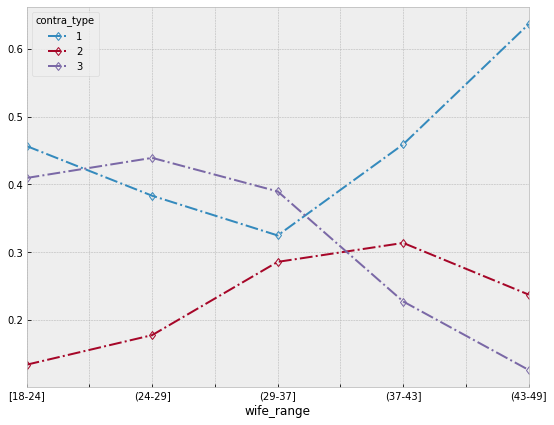

In [14]:
df_4 = pd.crosstab(df['wife_range'],df['contra_type'],normalize='index')
df_4.plot(marker='d',markerfacecolor='none',linestyle='-.',figsize=(9,7))

- Normalized the frequency counts due to the discrepancy in population. When looking at raw totals, it appears as though contraceptive type 1 decreases with age, but the proportion of women using no contraception actually appears to increase after around age 37.

In [15]:
df.drop(['wife_age','num_child'],axis=1,inplace=True)

In [16]:
for c in ['wife_edu','husb_edu','husb_occupation','life_std','contra_type']:
    df[c] = df[c].astype('category')

In [17]:
df_dummies = pd.get_dummies(df)
df_dummies.head()

,wife_islam,wife_unemployed,bad_media,wife_edu_1,wife_edu_2,wife_edu_3,wife_edu_4,husb_edu_1,husb_edu_2,husb_edu_3,...,contra_type_3,num_children_[0-1],num_children_(1-3],num_children_(3-6],num_children_(6-16],wife_range_[18-24],wife_range_(24-29],wife_range_(29-37],wife_range_(37-43],wife_range_(43-49]
0,1,1,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [18]:
def reorder_df(df,list_of_targets=None):
    #quick function to change column order in dataframe
    
    if list_of_targets is None:
        list_of_targets = ['contra_type_1','contra_type_2','contra_type_3']

    columns = list(df.columns)
    
    for i in list_of_targets:
        columns.pop(columns.index(i))
        columns.append(i)

    df = df.loc[:,columns]
    return df

In [19]:
df_dummies = reorder_df(df_dummies)

In [20]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 31 columns):
wife_islam             1473 non-null int64
wife_unemployed        1473 non-null int64
bad_media              1473 non-null int64
wife_edu_1             1473 non-null uint8
wife_edu_2             1473 non-null uint8
wife_edu_3             1473 non-null uint8
wife_edu_4             1473 non-null uint8
husb_edu_1             1473 non-null uint8
husb_edu_2             1473 non-null uint8
husb_edu_3             1473 non-null uint8
husb_edu_4             1473 non-null uint8
husb_occupation_1      1473 non-null uint8
husb_occupation_2      1473 non-null uint8
husb_occupation_3      1473 non-null uint8
husb_occupation_4      1473 non-null uint8
life_std_1             1473 non-null uint8
life_std_2             1473 non-null uint8
life_std_3             1473 non-null uint8
life_std_4             1473 non-null uint8
num_children_[0-1]     1473 non-null uint8
num_children_(1-3]     1473 non-n

In [21]:
df_features = df_dummies.iloc[:,:-3]
df_targets = df_dummies.iloc[:,-3:]

In [22]:
features_matrix = df_features.as_matrix()
targets_matrix = df_targets.as_matrix()

In [23]:
weights = np.zeros(features_matrix.shape[1])

In [24]:
predictions = sigmoid(np.dot(features_matrix,weights))

In [25]:
sum(np.round(predictions)==targets_matrix[:,0])/len(targets_matrix[:,0])

0.57298031228784796

In [26]:
predictions

array([ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5])

In [27]:
weights_gradient = np.dot(features_matrix.T,(predictions-targets_matrix[:,0]))
weights_gradient

array([  72.5,   93. ,  -19.5,  -27. ,   -9. ,   30. ,  113.5,   -9. ,
        -10. ,   15. ,  111.5,   60. ,   12.5,   34.5,    0.5,  -15.5,
         -2.5,   31.5,   94. ,  -51.5,   83.5,   76. ,   -0.5,   12. ,
         46. ,   67.5,    9. ,  -27. ])

In [28]:
#weights_gradient = weights_gradient / features_matrix.shape[0]
#weights_gradient

In [29]:
weights = weights - (weights_gradient*0.1)
weights

array([ -7.25,  -9.3 ,   1.95,   2.7 ,   0.9 ,  -3.  , -11.35,   0.9 ,
         1.  ,  -1.5 , -11.15,  -6.  ,  -1.25,  -3.45,  -0.05,   1.55,
         0.25,  -3.15,  -9.4 ,   5.15,  -8.35,  -7.6 ,   0.05,  -1.2 ,
        -4.6 ,  -6.75,  -0.9 ,   2.7 ])

## Testing Gradient Descent ##
### Target Variable: Contraceptive Type 1 (No Contraceptive)

- Keep in mind, this is not a final prediction
- No train/test split, just to peek at which factors have greatest influence on classification

In [30]:
weights = np.zeros(features_matrix.shape[1])
targets = targets_matrix[:,0]

row_list = []

for i in range(1000):
    prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
    weights_gradient = np.dot(features_matrix.T,(prediction_proba-targets)) / features_matrix.shape[0]
    
    weights = weights - (weights_gradient*0.1)
    
    predictions = np.round(prediction_proba)
    
    row_list.append([*weights,roc_auc_score(targets,prediction_proba),log_loss(prediction_proba,targets),accuracy_score(targets,predictions)])
    
    if i % 100 == 0:
        print(round(sum(predictions==targets)/len(targets_matrix[:,0]),5))
        
    ##early stopping: if AUC does not improve/change more than 0.1% between 50 loops, then loop is broken
        
    if i > 50:
        if abs((row_list[i][-3] - row_list[i-50][-3]) / row_list[i][-3]) < 0.0001:
            break
        
gradient_df = pd.DataFrame(row_list)
    
    

0.57298
0.67957
0.69179
0.6945
0.70129
0.69925
0.70536
0.70333
0.70265
0.70265


In [31]:
columns_list = list(df_features.columns)
columns_list.extend(('auc_score','log_loss','accuracy_score'))

In [32]:
top_auc_score = gradient_df.loc[:,28].idxmax(axis=1)

In [33]:
best_weights_for_loss= [(x,y) for x,y in zip(gradient_df.iloc[top_auc_score,].values,columns_list)]

In [34]:
best_weights_for_loss

[(0.20095338067552573, 'wife_islam'),
 (-0.20460235355056089, 'wife_unemployed'),
 (0.4559028257718612, 'bad_media'),
 (0.55217568193346889, 'wife_edu_1'),
 (0.33527960478373969, 'wife_edu_2'),
 (-0.08021798839129303, 'wife_edu_3'),
 (-0.76900929895317971, 'wife_edu_4'),
 (0.19029262033411412, 'husb_edu_1'),
 (-0.04062977564892311, 'husb_edu_2'),
 (-0.13226517537585017, 'husb_edu_3'),
 (0.020830330063394624, 'husb_edu_4'),
 (0.053630525525743447, 'husb_occupation_1'),
 (0.15256531273960733, 'husb_occupation_2'),
 (-0.056194444826306492, 'husb_occupation_3'),
 (-0.11177339406630847, 'husb_occupation_4'),
 (0.32422245187196841, 'life_std_1'),
 (0.080756189046482782, 'life_std_2'),
 (-0.09865194947969913, 'life_std_3'),
 (-0.26809869206601733, 'life_std_4'),
 (1.1909171898951885, 'num_children_[0-1]'),
 (-0.17506876910570013, 'num_children_(1-3]'),
 (-0.66118960339339505, 'num_children_(3-6]'),
 (-0.31643081802335599, 'num_children_(6-16]'),
 (-0.56619771987678691, 'wife_range_[18-24]'),


In [35]:
best_weights_for_loss_sorted = sorted(best_weights_for_loss[:-3],key= lambda x: x[0],reverse=True)

### Sanity Checks###

** Positive contributing factors to non-use of contraception: **

In [36]:
best_weights_for_loss_sorted[:5]

[(1.1909171898951885, 'num_children_[0-1]'),
 (0.90850466593558299, 'wife_range_(43-49]'),
 (0.55217568193346889, 'wife_edu_1'),
 (0.4559028257718612, 'bad_media'),
 (0.36133816474397989, 'wife_range_(37-43]')]

** Negative contributing factors to non-use of contraception: **

In [37]:
best_weights_for_loss_sorted[-5:]

[(-0.31643081802335599, 'num_children_(6-16]'),
 (-0.44377729394129922, 'wife_range_(24-29]'),
 (-0.56619771987678691, 'wife_range_[18-24]'),
 (-0.66118960339339505, 'num_children_(3-6]'),
 (-0.76900929895317971, 'wife_edu_4')]

In [38]:
bern = BernoulliNB(alpha=0.1)

In [39]:
bern.fit(features_matrix,targets_matrix[:,0])

BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)

In [40]:
sum(bern.predict(features_matrix) == targets_matrix[:,0]) / len(targets_matrix[:,0])

0.65241004752206377

- Is my homemade function/ for-loop outperforming out of the box Bernoulli NB??

### Optimize with regularization? ##

- Going to try two methods and see their effect on predictions:
    1. L-1 (RIDGE): Add weights' Sum of Squares multiplied by a lambda constant to avoid over-fitting
    2. L-2 (LASSO): Add weights' Sum of Absolute Values multiplied by lambda constant, which reduces less important factors to zero (feature selection)

### Ridge Regression

In [41]:
weights = np.zeros(features_matrix.shape[1])
targets = targets_matrix[:,0]

epsilon = 1

row_list = []

for i in range(1000):
    prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
    weights_gradient = (np.dot(features_matrix.T,(prediction_proba-targets)) / features_matrix.shape[0]) + ((epsilon/(2*len(targets))) * np.sum(np.square(weights)))
    
    weights = weights - (weights_gradient*0.1) 
    
    #print(weights)
    
    predictions = np.round(prediction_proba)
    
    row_list.append([*weights,roc_auc_score(targets,prediction_proba),log_loss(prediction_proba,targets),accuracy_score(targets,predictions)])
    
    if i % 100 == 0:
        print(round(sum(predictions==targets)/len(targets_matrix[:,0]),5))
        
    ##early stopping: if AUC does not improve/change more than 0.1% between 50 loops, then loop is broken
        
    if i > 50:
        if abs((row_list[i][-3] - row_list[i-50][-3]) / row_list[i][-3]) < 0.001:
            break
        
gradient_df_ridge = pd.DataFrame(row_list)

0.57298
0.67957
0.69111
0.69586
0.69857
0.70061


In [42]:
top_auc_score_ridge = gradient_df_ridge.loc[:,28].idxmax(axis=1)

In [43]:
top_auc_score_ridge

495

In [44]:
best_weights_for_loss_ridge= [(x,y) for x,y in zip(gradient_df_ridge.iloc[top_auc_score_ridge,].values,columns_list)]

In [45]:
best_weights_for_loss_ridge_sorted = sorted(best_weights_for_loss_ridge[:-3],key= lambda x: x[0],reverse=True)

In [46]:
best_weights_for_loss_sorted[:5]

[(1.1909171898951885, 'num_children_[0-1]'),
 (0.90850466593558299, 'wife_range_(43-49]'),
 (0.55217568193346889, 'wife_edu_1'),
 (0.4559028257718612, 'bad_media'),
 (0.36133816474397989, 'wife_range_(37-43]')]

In [47]:
best_weights_for_loss_ridge_sorted[:5]

[(0.95424133305203884, 'num_children_[0-1]'),
 (0.68861220830292169, 'wife_range_(43-49]'),
 (0.44156747958368625, 'wife_edu_1'),
 (0.34841721819776517, 'bad_media'),
 (0.26988058071211213, 'wife_edu_2')]

In [48]:
for l, r in zip(best_weights_for_loss_sorted,best_weights_for_loss_ridge_sorted):
    print(round(l[0],4),round(r[0],4),l[1])

1.1909 0.9542 num_children_[0-1]
0.9085 0.6886 wife_range_(43-49]
0.5522 0.4416 wife_edu_1
0.4559 0.3484 bad_media
0.3613 0.2699 wife_range_(37-43]
0.3353 0.2446 wife_edu_2
0.3242 0.2324 life_std_1
0.201 0.1946 wife_islam
0.1903 0.1301 husb_edu_1
0.1526 0.1253 husb_occupation_2
0.0808 0.0764 life_std_2
0.0536 0.0222 husb_occupation_1
0.0208 0.012 husb_edu_4
-0.0406 -0.0339 husb_edu_2
-0.0562 -0.0659 husb_occupation_3
-0.0802 -0.0693 wife_edu_3
-0.0987 -0.0745 life_std_3
-0.1118 -0.0896 husb_occupation_4
-0.1323 -0.1162 husb_edu_3
-0.1751 -0.1413 num_children_(1-3]
-0.2046 -0.1592 wife_unemployed
-0.2216 -0.2293 wife_range_(29-37]
-0.2681 -0.2396 life_std_4
-0.3164 -0.2563 num_children_(6-16]
-0.4438 -0.3406 wife_range_(24-29]
-0.5662 -0.3493 wife_range_[18-24]
-0.6612 -0.5712 num_children_(3-6]
-0.769 -0.6348 wife_edu_4


- Ridge, at least with an epsilon of 50, performs slightly better

In [49]:
l1 = [n for n, v in best_weights_for_loss]
l2 = [n for n, v in best_weights_for_loss_ridge]

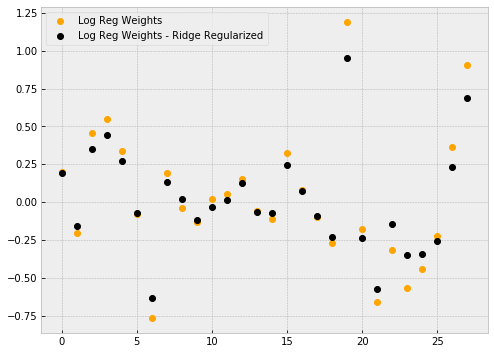

In [50]:
plt.figure(figsize=(8,6))

plt.plot(l1[:-3],marker='o',linestyle='none',color='orange',label='Log Reg Weights')
plt.plot(l2[:-3],marker='o',linestyle='none',color='black',label='Log Reg Weights - Ridge Regularized')
plt.legend(loc=0)
plt.show()
#plt.plot(l1[3:],l2[3:])

### LASSO Regression

In [51]:
weights = np.zeros(features_matrix.shape[1])
targets = targets_matrix[:,0]

alpha = .9

row_list = []

for i in range(1000):
    prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
    weights_gradient = (np.dot(features_matrix.T,(prediction_proba-targets)) / features_matrix.shape[0]) + np.sum((alpha/(2*len(targets))) * (np.abs(weights)))
    
    weights = weights - (weights_gradient*0.1) 
    
    #print(weights)
    
    predictions = np.round(prediction_proba)
    
    row_list.append([*weights,roc_auc_score(targets,prediction_proba),log_loss(prediction_proba,targets),accuracy_score(targets,predictions)])
    
    if i % 100 == 0:
        print(round(sum(predictions==targets)/len(targets_matrix[:,0]),5))
        
    ##early stopping: if AUC does not improve/change more than 0.1% between 50 loops, then loop is broken
        
    if i > 50:
        if abs((row_list[i][-2] - row_list[i-50][-2]) / row_list[i][-3]) < 0.00001:
            break
        
gradient_df_lasso = pd.DataFrame(row_list)

0.57298
0.67889
0.68703
0.69111
0.69586
0.69993
0.70401
0.70333
0.70333
0.70468


In [52]:
top_auc_score_lasso = gradient_df_lasso.loc[:,28].idxmax(axis=0)
top_auc_score_lasso

988

In [53]:
best_weights_for_loss_lasso= [(x,y) for x,y in zip(gradient_df_lasso.iloc[top_auc_score_lasso,].values[:-3],columns_list[:-3])]

In [54]:
best_weights_for_loss_lasso[:5]

[(0.36716178304402158, 'wife_islam'),
 (-0.12116544781124015, 'wife_unemployed'),
 (0.39261960368992727, 'bad_media'),
 (0.49085001080847418, 'wife_edu_1'),
 (0.2904169081543217, 'wife_edu_2')]

In [55]:
l1 = [n for n, v in best_weights_for_loss]
l2 = [n for n, v in best_weights_for_loss_lasso]

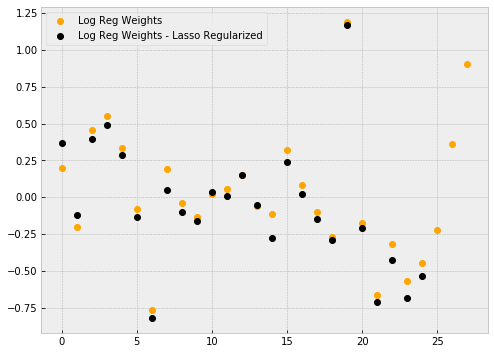

In [56]:
plt.figure(figsize=(8,6))

plt.plot(l1[:-3],marker='o',linestyle='none',color='orange',label='Log Reg Weights')
plt.plot(l2[:-3],marker='o',linestyle='none',color='black',label='Log Reg Weights - Lasso Regularized')
plt.legend(loc=0)
plt.show()
#plt.plot(l1[3:],l2[3:])

In [57]:
gradient_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-0.004922,-0.006314,0.001324,0.001833,0.000611,-0.002037,-0.007705,0.000611,0.000679,-0.001018,...,-0.005160,0.000034,-0.000815,-0.003123,-0.004582,-0.000611,0.001833,0.500000,0.693147,0.572980
1,-0.009266,-0.012088,0.002679,0.003707,0.001338,-0.003894,-0.015063,0.001232,0.001406,-0.001915,...,-0.010105,0.000115,-0.001522,-0.006057,-0.008957,-0.001120,0.003744,0.691385,0.689578,0.574338
2,-0.013082,-0.017369,0.004061,0.005616,0.002171,-0.005588,-0.022098,0.001862,0.002175,-0.002701,...,-0.014852,0.000237,-0.002132,-0.008819,-0.013139,-0.001534,0.005726,0.692373,0.686404,0.575696
3,-0.016416,-0.022198,0.005468,0.007557,0.003097,-0.007132,-0.028833,0.002499,0.002981,-0.003388,...,-0.019418,0.000397,-0.002655,-0.011423,-0.017142,-0.001862,0.007771,0.693341,0.683567,0.575696
4,-0.019310,-0.026614,0.006896,0.009525,0.004107,-0.008540,-0.035291,0.003143,0.003820,-0.003986,...,-0.023815,0.000590,-0.003100,-0.013882,-0.020980,-0.002111,0.009875,0.694253,0.681016,0.576375


In [58]:
weights_history = gradient_df_lasso.iloc[:,:-3]
scores_history = gradient_df_lasso.iloc[:,-3:]

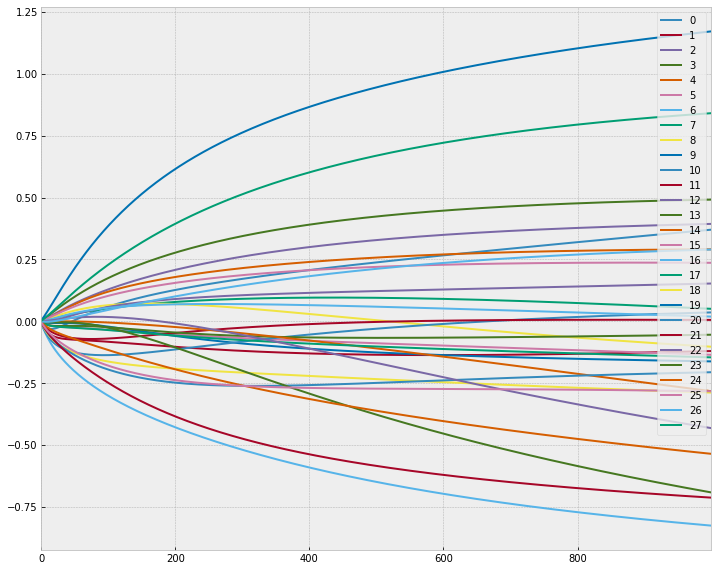

In [59]:
weights_history.plot(figsize=(12,10))

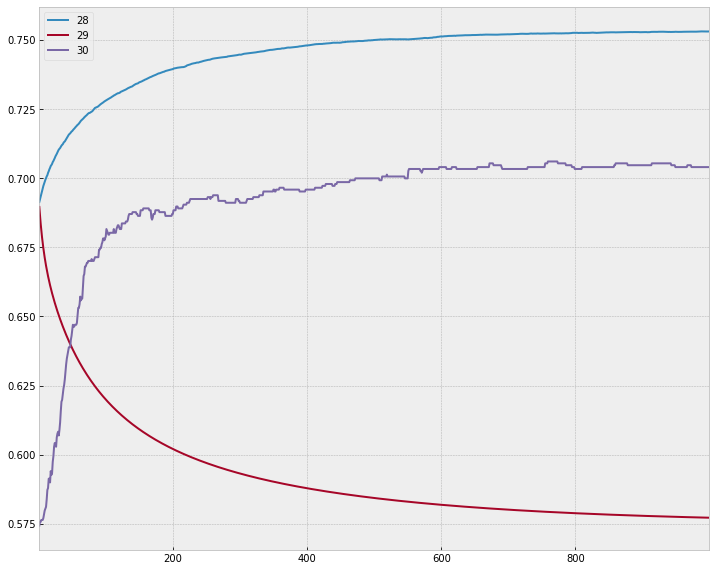

In [60]:
scores_history.iloc[1:,:].plot(figsize=(12,10))

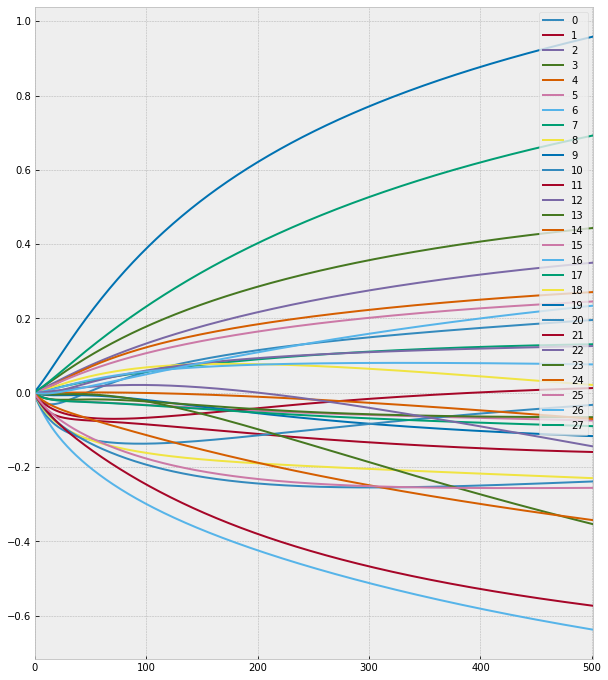

In [61]:
weights_history_ridge = gradient_df_ridge.iloc[:,:-3]
weights_history_ridge.plot(figsize=(10,12))
plt.show()

In [62]:
def gradient_descent(features_matrix,targets,full_history=False):
    weights = np.zeros(features_matrix.shape[1])
    
    alpha = 0.1
    epsilon = 10
    
    weights_list = []
    
    scores_list = []
    
    for i in range(1000):
        
            prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
            weights_gradient = np.dot(features_matrix.T,(prediction_proba-targets))# / features_matrix.shape[0]
            
            weights = weights*(1 - (epsilon * (alpha/len(features_matrix)))) - ((alpha*weights_gradient)/len(features_matrix))#*0.01)
        
            prediction_proba = sigmoid(np.dot(features_matrix,weights))
    
            predictions = np.round(prediction_proba)
    
            weights_list.append([*weights])
 
            scores_list.append([roc_auc_score(targets,prediction_proba),log_loss(prediction_proba,targets),accuracy_score(targets,predictions)])

            ##early stopping: if AUC does not improve/change more than 0.01% between 50 loops, then loop is broken
        
            if i > 50:
                if abs((scores_list[i][-3] - scores_list[i-50][-3]) / scores_list[i][-3]) < 0.0001:
                    break
    scores_df = pd.DataFrame(scores_list)
    
    ID = scores_df.iloc[:,0].idxmax(axis=0)
    
    weights_final = weights_list[ID]
    
    weights_df = pd.DataFrame(weights_list)
    
    full_df = pd.concat([weights_df,scores_df],axis=1)
    
    if full_history:
        return full_df
    
    return weights_final

In [63]:
weighting = [gradient_descent(features_matrix,targets_matrix[:,i]) for i in range(targets_matrix.shape[1])]

In [64]:
weighting_array = np.array(weighting)

In [65]:
predictions = sigmoid(np.dot(features_matrix,weighting_array.T))

In [66]:
predictions_df = pd.DataFrame(predictions)

In [67]:
concatenated = pd.concat([predictions_df,df_targets],axis=1)

In [68]:
concatenated.head(15)

,0,1,2,contra_type_1,contra_type_2,contra_type_3
0,0.406312,0.095017,0.521273,1,0,0
1,0.640438,0.138505,0.217431,1,0,0
2,0.488886,0.183840,0.280593,1,0,0
3,0.468270,0.223178,0.288794,1,0,0
4,0.362943,0.187789,0.424183,1,0,0
5,0.444512,0.153982,0.344668,1,0,0
6,0.474386,0.142061,0.345833,1,0,0
7,0.644358,0.083507,0.340180,1,0,0
8,0.339324,0.101121,0.551691,1,0,0
9,0.844208,0.121242,0.095933,1,0,0


In [69]:
numbers = predictions_df.idxmax(axis=1)

In [70]:
ones_numbers = pd.get_dummies(numbers)

In [71]:
ones_numbers.head(10)

,0,1,2
0,0,0,1
1,1,0,0
2,1,0,0
3,1,0,0
4,0,0,1
5,1,0,0
6,1,0,0
7,1,0,0
8,0,0,1
9,1,0,0


In [72]:
sum(ones_numbers.values == df_targets.values) / len(ones_numbers)

array([ 0.68771215,  0.76714189,  0.65716225])

In [73]:
logreg = LogisticRegression(C=1)

In [74]:
ovrc = OneVsRestClassifier(logreg)

In [75]:
ovrc.fit(features_matrix,targets_matrix)

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [76]:
probabilities_df = pd.DataFrame(ovrc.predict_proba(features_matrix))

In [77]:
rounded_predictions = probabilities_df.idxmax(axis=1)

In [78]:
ones_rounded_predictions = pd.get_dummies(rounded_predictions)

In [79]:
sum(ones_rounded_predictions.values == targets_matrix) / (ones_rounded_predictions.shape[0])

array([ 0.69653768,  0.766463  ,  0.66395112])

#### Very similar results between OneVsRestClassifier/Logistic Regression and my homemade algorithm

In [80]:
auc_scores_homemade = [roc_auc_score(targets_matrix[:,i],predictions_df.iloc[:,i].values) for i in range(targets_matrix.shape[1])]

In [81]:
auc_scores_homemade

[0.75132045901491118, 0.74098967388441073, 0.70156657485424612]

In [82]:
auc_scores_ovrc = [roc_auc_score(targets_matrix[:,i],probabilities_df.iloc[:,i].values) for i in range(targets_matrix.shape[1])]

In [83]:
auc_scores_ovrc

[0.75433622917592813, 0.74940335071914022, 0.70714448454174483]

In [84]:
list_of_dfs = [gradient_descent(features_matrix,targets_matrix[:,i],full_history=True) for i in range(targets_matrix.shape[1])]

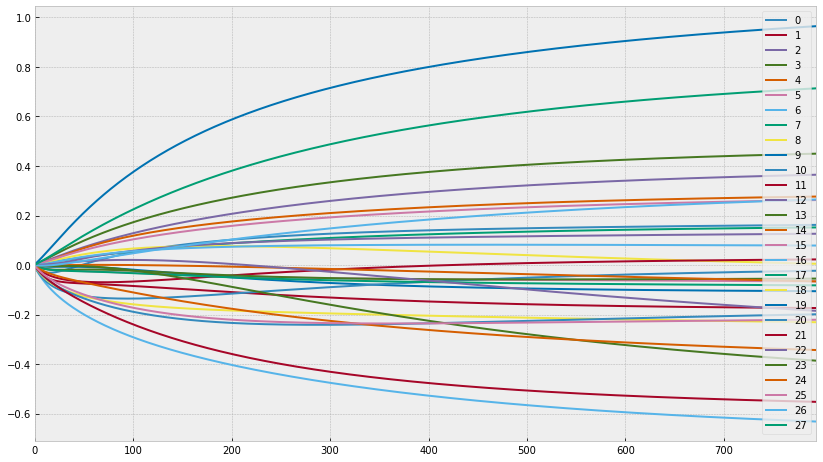

In [85]:
list_of_dfs[0].iloc[:,:-3].plot(subplots=False,figsize=(14,8))
plt.show()

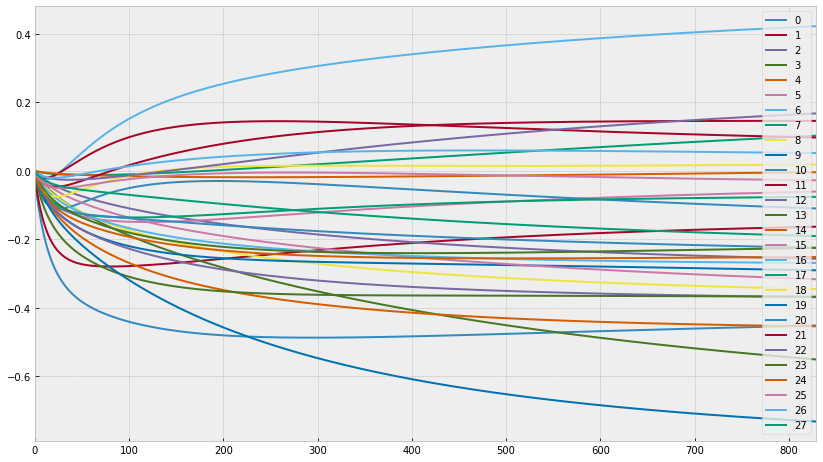

In [86]:
list_of_dfs[1].iloc[:,:-3].plot(subplots=False,figsize=(14,8))
plt.show()

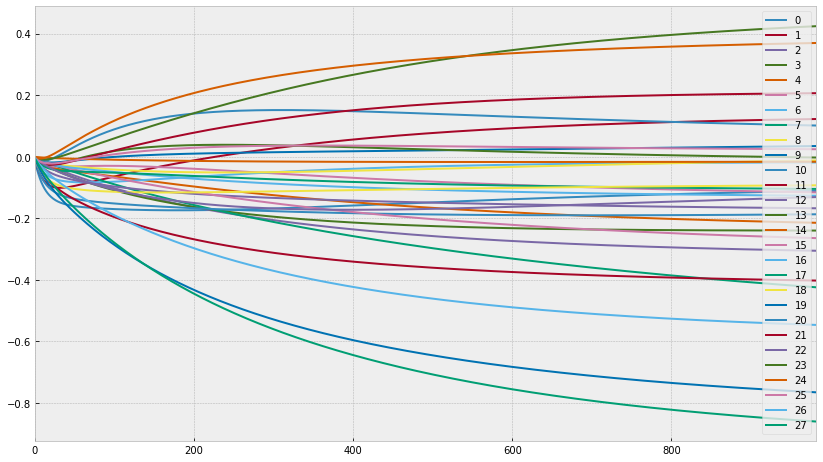

In [87]:
list_of_dfs[2].iloc[:,:-3].plot(subplots=False,figsize=(14,8))
plt.show()

In [88]:
from data_tools import log_reg

In [89]:
clf = log_reg.BinaryClassifier(regularization={'ridge':1})

In [90]:
clf._gradient_descent(features_matrix,targets_matrix[:,0])

this test worked!


([0.13725214163827307,
  -0.15203351869759846,
  0.30659502707821429,
  0.38343638969703514,
  0.23803676622824971,
  -0.057480364047735447,
  -0.54418512620806891,
  0.128025319913809,
  0.028916309490815761,
  -0.087360857095586095,
  -0.049773106639558792,
  0.0035563583183065425,
  0.10995227430158809,
  -0.051293655544685818,
  -0.042407311405728974,
  0.22314976261173963,
  0.075593436035791495,
  -0.070618203076511191,
  -0.20831732990153984,
  0.82054777175898752,
  -0.20638550900751512,
  -0.47971890037701848,
  -0.11463569670497235,
  -0.28144418330753507,
  -0.28182381469625484,
  -0.21514088302716522,
  0.20675872322167121,
  0.5914578234787643],
             0         1         2         3         4         5         6  \
 0   -0.004922 -0.006314  0.001324  0.001833  0.000611 -0.002037 -0.007705   
 1   -0.009259 -0.012080  0.002677  0.003704  0.001338 -0.003891 -0.015052   
 2   -0.013064 -0.017345  0.004056  0.005609  0.002168 -0.005580 -0.022067   
 3   -0.016382 -0.022

In [91]:
clf.weights_final


[0.13725214163827307,
 -0.15203351869759846,
 0.30659502707821429,
 0.38343638969703514,
 0.23803676622824971,
 -0.057480364047735447,
 -0.54418512620806891,
 0.128025319913809,
 0.028916309490815761,
 -0.087360857095586095,
 -0.049773106639558792,
 0.0035563583183065425,
 0.10995227430158809,
 -0.051293655544685818,
 -0.042407311405728974,
 0.22314976261173963,
 0.075593436035791495,
 -0.070618203076511191,
 -0.20831732990153984,
 0.82054777175898752,
 -0.20638550900751512,
 -0.47971890037701848,
 -0.11463569670497235,
 -0.28144418330753507,
 -0.28182381469625484,
 -0.21514088302716522,
 0.20675872322167121,
 0.5914578234787643]

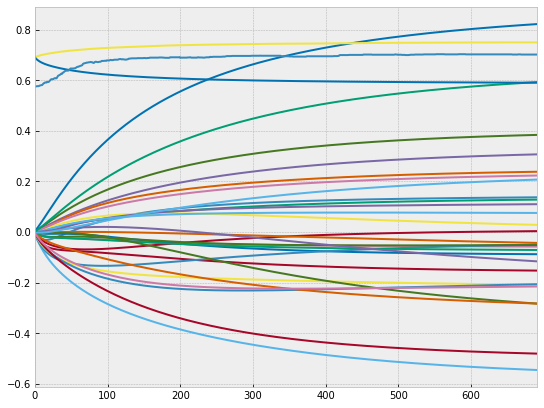

In [92]:
clf.full_history.plot(legend=False,figsize=(9,7))

In [93]:
clf_01 = log_reg.BinaryClassifier(regularization={'ridge':.5})

In [94]:
clf_01._gradient_descent(features_matrix,targets_matrix[:,0])

this test worked!


([0.16230997600259126,
  -0.17329774196902573,
  0.36472018172622062,
  0.44970585652069783,
  0.27661002920107558,
  -0.065722371734088805,
  -0.63141117578031736,
  0.15200570620368661,
  0.0054779192026213619,
  -0.10537710056594198,
  -0.022924186632998195,
  0.022879234908635592,
  0.12648093425004037,
  -0.054513978830756135,
  -0.065663852120551883,
  0.26248766819453806,
  0.078958626099807097,
  -0.081707257551969267,
  -0.2305566985350079,
  0.96423455339036324,
  -0.1986919050019407,
  -0.551978704556356,
  -0.18438160562469838,
  -0.38555869984727825,
  -0.34279101163022074,
  -0.22059076491230764,
  0.26474426287139929,
  0.71337855172577724],
             0         1         2         3         4         5         6  \
 0   -0.004922 -0.006314  0.001324  0.001833  0.000611 -0.002037 -0.007705   
 1   -0.009263 -0.012084  0.002678  0.003705  0.001338 -0.003893 -0.015058   
 2   -0.013073 -0.017357  0.004059  0.005612  0.002169 -0.005584 -0.022082   
 3   -0.016399 -0.02217

Text(0,0.5,'weighting')

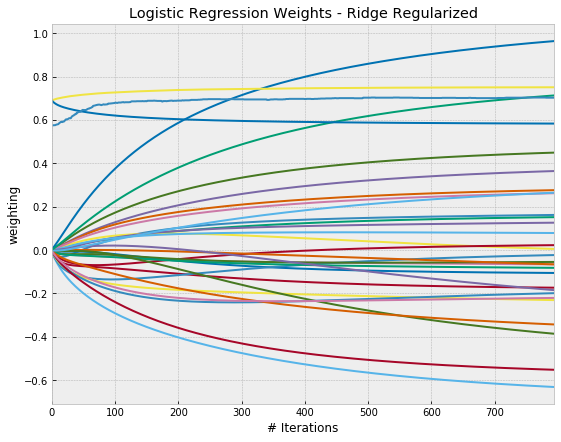

In [95]:
clf_01.full_history.plot(legend=False,figsize=(9,7),title='Logistic Regression Weights - Ridge Regularized')
plt.xlabel('# Iterations')
plt.ylabel('weighting')

In [96]:
clf_01.full_history.iloc[:,-3:].tail()

,auc,loss,acc
790,0.751307,0.583878,0.703327
791,0.751304,0.583869,0.703327
792,0.751317,0.583860,0.703327
793,0.751320,0.583851,0.703327
794,0.751313,0.583841,0.703327


In [97]:
clf.full_history.iloc[:,-3:].tail()

,auc,loss,acc
687,0.749444,0.590094,0.70129
688,0.749444,0.590085,0.70129
689,0.749442,0.590076,0.70129
690,0.749431,0.590067,0.70129
691,0.749429,0.590057,0.70129


### Ridge with lambda of 0.5 appears to perform better than not having a Regularization parameter

In [139]:
lasso_clf = BinaryClassifier({'lasso':.5})

In [140]:
lasso_clf._gradient_descent(features_matrix,targets_matrix[:,0])

this test worked!


([-8.4983177071273181e-05,
  -0.11293067797591784,
  0.23204164928231863,
  0.35996412616896201,
  0.11211165150290529,
  -0.06543072376878728,
  -0.68712967026875882,
  -0.00028616718553350879,
  0.00054113906684984678,
  -0.00011267930959662164,
  -0.00092561905283454146,
  0.00030147055991959872,
  0.00015178419143794695,
  -0.012133651284950213,
  3.4884037541377559e-05,
  0.067467790821586077,
  0.00063344485732130991,
  -0.0035879181889055499,
  -0.16848741111301516,
  0.93628687737062033,
  -0.11205037205619044,
  -0.4003236686638969,
  0.00028686470266036447,
  -0.17433502437491905,
  -0.20056276927259895,
  -0.11069146557346009,
  0.11267030151489792,
  0.66473576700226211],
             0         1         2         3         4         5         6  \
 0   -0.004922 -0.006314  0.001324  0.001833  0.000611 -0.002037 -0.007705   
 1   -0.008587 -0.011409  0.002000  0.003028  0.000660 -0.003215 -0.014384   
 2   -0.011798 -0.016079  0.002702  0.004255  0.000800 -0.004258 -0.02078

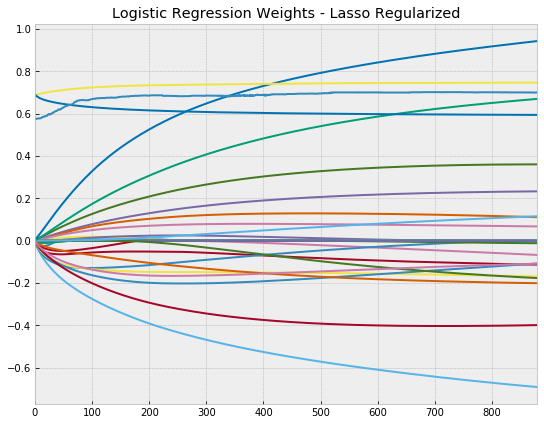

In [141]:
lasso_clf.full_history.plot(legend=False,figsize=(9,7),title='Logistic Regression Weights - Lasso Regularized')
plt.show()

In [142]:
lasso_clf.weights_final

[-8.4983177071273181e-05,
 -0.11293067797591784,
 0.23204164928231863,
 0.35996412616896201,
 0.11211165150290529,
 -0.06543072376878728,
 -0.68712967026875882,
 -0.00028616718553350879,
 0.00054113906684984678,
 -0.00011267930959662164,
 -0.00092561905283454146,
 0.00030147055991959872,
 0.00015178419143794695,
 -0.012133651284950213,
 3.4884037541377559e-05,
 0.067467790821586077,
 0.00063344485732130991,
 -0.0035879181889055499,
 -0.16848741111301516,
 0.93628687737062033,
 -0.11205037205619044,
 -0.4003236686638969,
 0.00028686470266036447,
 -0.17433502437491905,
 -0.20056276927259895,
 -0.11069146557346009,
 0.11267030151489792,
 0.66473576700226211]

In [143]:
std_clf = BinaryClassifier()

In [130]:
std_clf._gradient_descent(features_matrix,targets_matrix[:,0])

this test worked!


([0.20089507737756324,
  -0.20457744863690577,
  0.45577353397057369,
  0.55204808892076984,
  0.33520542272829101,
  -0.080184576581062067,
  -0.76879838828909197,
  0.19024135760238273,
  -0.040493641386989986,
  -0.1322357426719267,
  0.02075857323544027,
  0.053591995371656188,
  0.15252081241037932,
  -0.056219954329724438,
  -0.11162230667340436,
  0.32413208401676463,
  0.080780999251951313,
  -0.09862199130194578,
  -0.26802054518786483,
  1.1905595977256658,
  -0.17517340447378935,
  -0.66105553687725982,
  -0.31606010959570852,
  -0.56581184767716508,
  -0.4435869661336817,
  -0.22168187402943756,
  0.36115519245867311,
  0.90819604216051764],
             0         1         2         3         4         5         6  \
 0   -0.004922 -0.006314  0.001324  0.001833  0.000611 -0.002037 -0.007705   
 1   -0.009266 -0.012088  0.002679  0.003707  0.001338 -0.003894 -0.015063   
 2   -0.013082 -0.017369  0.004061  0.005616  0.002171 -0.005588 -0.022098   
 3   -0.016416 -0.022198  

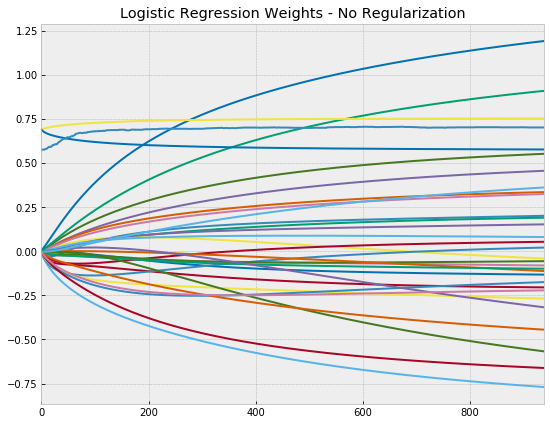

In [131]:
std_clf.full_history.plot(legend=False,figsize=(9,7),title='Logistic Regression Weights - No Regularization')
plt.show()